<a href="https://colab.research.google.com/github/sola-adewumi/Storm_prediction_xai/blob/main/TimeSHAP_dummy_m2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ==================================================================================
#   SECTION 1: Create Sequences from Data (single-location,SMILE RNN model)
# ==================================================================================

### Step 1: Install Required Packages

In [ ]:
!%pip install pandas numpy
import numpy as np
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.utils import resample
from tensorflow.keras.layers import SimpleRNN,Input, Dense
from sklearn.preprocessing import MinMaxScaler
from itertools import product

!%pip install shap dash plotly pandas numpy scikit-learn matplotlib seaborn
import tensorflow as tf

print("TensorFlow GPU available:", len(tf.config.experimental.list_physical_devices('GPU')) > 0)


def force_detection():
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU memory growth enabled. TensorFlow is using the GPU.")
        print("TensorFlow GPU available:", True)
    else:
        print("TensorFlow GPU available:", False)



/bin/bash: line 1: fg: no job control
/bin/bash: line 1: fg: no job control
TensorFlow GPU available: True


### Step 2: Generate 90/180 Days of Training Data

Background Shape (BG): (5,)

Background Values (BG): Temp       19.901192
Press    1010.054526
Hum        74.990066
Wind       15.060831
Storm       0.000000
dtype: float64

Generated 18 sequences, each of length 5.

Sequence 1:
        Date       Temp        Press        Hum       Wind  Storm
0 2025-01-01  20.496714  1010.097078  75.625667  16.441273      0
1 2025-01-02  21.269001  1012.375910  76.253740  14.267770      0
2 2025-01-03  23.434210  1012.084468  78.108889  17.556424      1
3 2025-01-04  25.633347  1013.782655  81.647948  17.065392      0
4 2025-01-05  25.118152  1014.960198  82.804996  16.694644      0

Sequence 2:
        Date       Temp        Press        Hum       Wind  Storm
5 2025-01-06  26.253631  1015.024253  85.445652  18.705987      1
6 2025-01-07  29.073316  1017.790224  86.714393  18.946111      0
7 2025-01-08  29.118719  1018.612340  87.454098  18.575425      1
8 2025-01-09  28.572775  1019.047363  87.716581  19.590927      0
9 2025-01-10  30.095807  1019.31

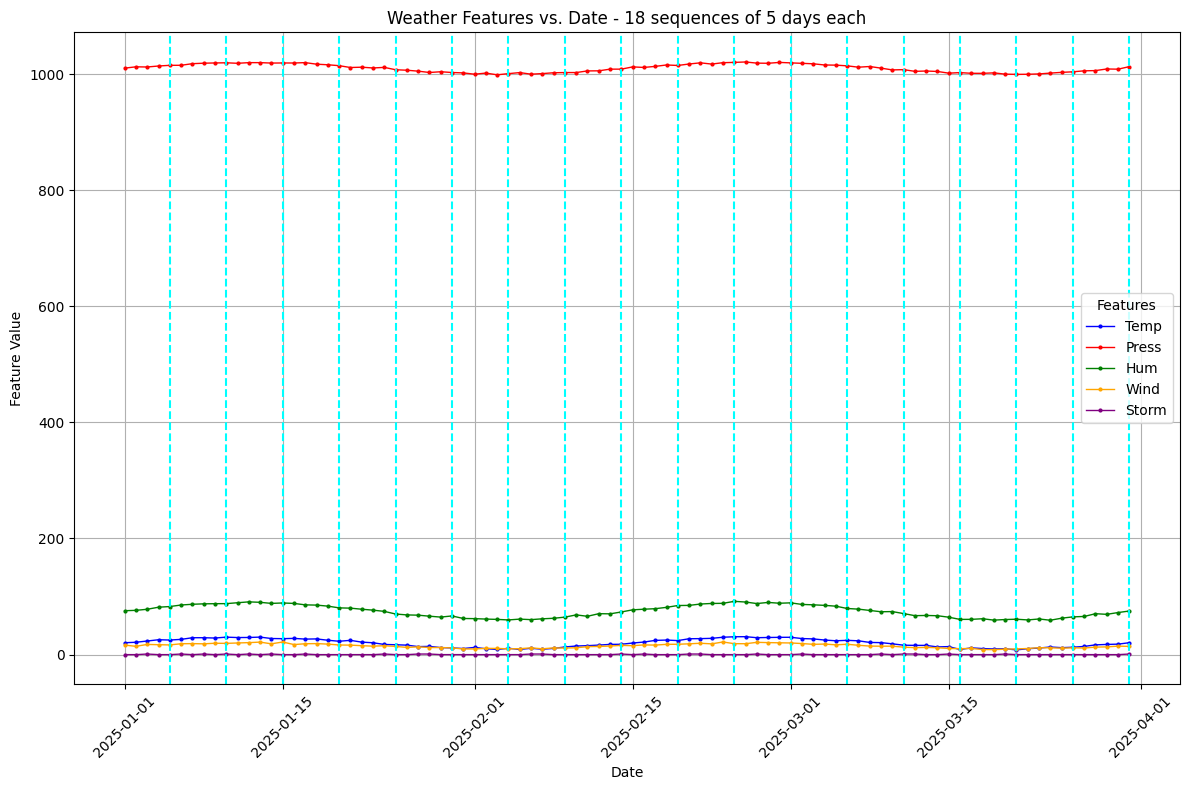

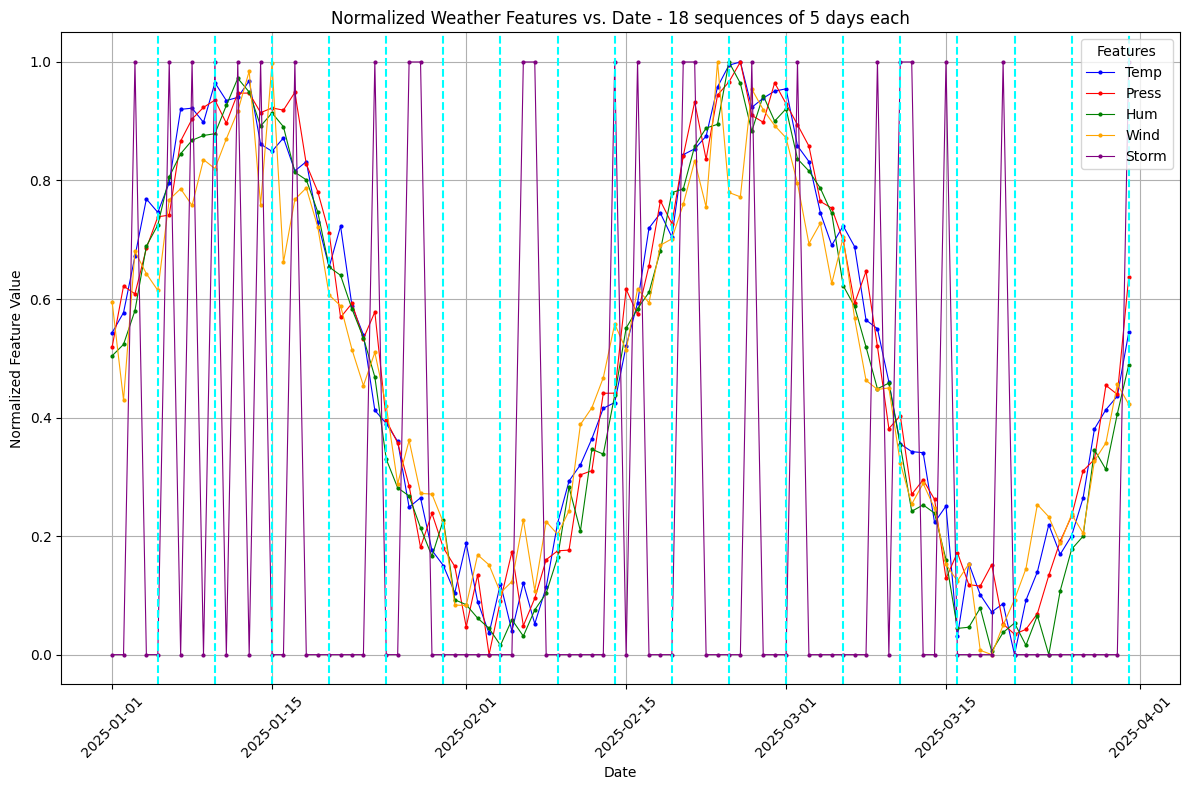

In [ ]:
# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Generate 90 days of daily data
num_days = 90
sequence_length = 5

# Generate sinewave data for each feature (daily averages) with noise
df_sinewave = pd.DataFrame({
    "Date": pd.date_range(start="2025-01-01", periods=num_days, freq="D"),
    "Temp": 20 + 10 * np.sin(np.linspace(0, 4 * np.pi, num_days)) + np.random.normal(0, 1, num_days),
    "Press": 1010 + 10 * np.sin(np.linspace(0, 4 * np.pi, num_days)) + np.random.normal(0, 1, num_days),
    "Hum": 75 + 15 * np.sin(np.linspace(0, 4 * np.pi, num_days)) + np.random.normal(0, 1, num_days),
    "Wind": 15 + 5 * np.sin(np.linspace(0, 4 * np.pi, num_days)) + np.random.normal(0, 1, num_days),
    "Storm": np.random.choice([0, 1], num_days, p=[0.85, 0.15])
})

df_sinewave['Date'] = pd.to_datetime(df_sinewave['Date'])

# Compute Background Values (Mean for Continuous, Mode for Binary Features)
background_values = df_sinewave.drop(columns=['Date']).mean()
background_values['Storm'] = df_sinewave['Storm'].mode()[0]

print("Background Shape (BG):", background_values.shape)
print("\nBackground Values (BG):", background_values)

# Create Sequences (Modified to be independent of sequence_length)
def create_sequences(df, sequence_length):
    sequences = []
    for i in range(0, len(df) - sequence_length + 1, sequence_length):
        sequence = df.iloc[i:i + sequence_length].copy()
        sequence["Sequence_ID"] = len(sequences) + 1
        sequences.append(sequence)
    return pd.concat(sequences).reset_index(drop=True), len(sequences)

# Specify `sequence_length`, and number of sequences is auto-calculated
df_sequences, num_sequences = create_sequences(df_sinewave, sequence_length)

print(f"\nGenerated {num_sequences} sequences, each of length {sequence_length}.")

# Print out all the data in each sequence length for all the sequences, excluding the Sequence_ID column
for seq_id in range(1, num_sequences + 1):
    print(f"\nSequence {seq_id}:")
    print(df_sequences[df_sequences['Sequence_ID'] == seq_id].drop(columns=['Sequence_ID']))

# Define Features and Colors for Plotting
features = ['Temp', 'Press', 'Hum', 'Wind', 'Storm']
colors = ['blue', 'red', 'green', 'orange', 'purple']

# Function to Plot Original Data Without Coalitions
def plot_original_data(df, features, colors):
    plt.figure(figsize=(12, 8))

    for i, feature in enumerate(features):
        plt.plot(df['Date'], df[feature], marker='o', markersize=2, linestyle='-', color=colors[i], label=feature, linewidth=1)

    # Add vertical lines at the end of each sequence length
    for seq_id in range(1, num_sequences + 1):
        end_date = df[df['Sequence_ID'] == seq_id]['Date'].max()
        plt.axvline(x=end_date, color='aqua', linestyle='--')

    plt.title(f"Weather Features vs. Date - {num_sequences} sequences of {sequence_length} days each")
    plt.xlabel('Date')
    plt.ylabel('Feature Value')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(title='Features')
    plt.tight_layout()
    plt.show()

# Function to Plot Normalized Data Without Coalitions
def plot_normalized_original_data(df, features, colors, scaler):
    df_normalized = df.copy()

    for feature in features:
        df_normalized[feature] = scaler.fit_transform(df[[feature]])

    plt.figure(figsize=(12, 8))

    for i, feature in enumerate(features):
        plt.plot(df_normalized['Date'], df_normalized[feature], marker='o', markersize=2, linestyle='-', color=colors[i], label=feature, linewidth=0.8)

    # Add vertical lines at the end of each sequence length
    for seq_id in range(1, num_sequences + 1):
        end_date = df[df['Sequence_ID'] == seq_id]['Date'].max()
        plt.axvline(x=end_date, color='aqua', linestyle='--')

    plt.title(f"Normalized Weather Features vs. Date - {num_sequences} sequences of {sequence_length} days each")
    plt.xlabel('Date')
    plt.ylabel('Normalized Feature Value')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(title='Features')
    plt.tight_layout()
    plt.show()

# Plot Data
plot_original_data(df_sequences, features, colors)
plot_normalized_original_data(df_sequences, features, colors, MinMaxScaler())

### Step 3: Extract 18 number of sequences (with 5-day sequence_length per sequence) for the full 90-day dataset

# =============================================================================
#   SECTION 2: Coalitions of 2^m combinations of events(rows) or features are required to explain the original prediction for a sequence
# ============================================================================


### Step 1a: Perturbation Function : for row(event)-wise explanability

In [ ]:
def generate_perturbations(sequence, sequence_id, background_values):
    num_rows = len(sequence)
    num_coalitions = 2 ** num_rows

    perturbed_sequences = []
    print(f"Original Sequence {sequence_id}:\n", sequence)

    # Generate unique binary masks for all coalitions (2^m)
    all_masks = list(product([0, 1], repeat=num_rows))

    for coalition, mask_values in enumerate(all_masks):
        perturbed_seq = sequence.copy()
        mask = pd.Series(mask_values, index=sequence.index)

        # Apply perturbation based on the mask (0 → Replace with background, 1 → Keep original)
        rows_to_replace = sequence.index[mask == 0]

        # Replace missing values using the dataset mean
        perturbed_seq.loc[rows_to_replace, background_values.index] = background_values.values

        # Store the mask
        perturbed_seq['Mask'] = mask

        perturbed_sequences.append(perturbed_seq)
        print(f"Perturbed Sequence {sequence_id}; Coalition {coalition}:\n", perturbed_seq)

    return perturbed_sequences


# Example usage
sequence_id = 1
sequence = df_sequences[df_sequences['Sequence_ID'] == sequence_id].drop(columns=['Sequence_ID'])
perturbed_sequences = generate_perturbations(sequence, sequence_id, background_values)


Original Sequence 1:
         Date       Temp        Press        Hum       Wind  Storm
0 2025-01-01  20.496714  1010.097078  75.625667  16.441273      0
1 2025-01-02  21.269001  1012.375910  76.253740  14.267770      0
2 2025-01-03  23.434210  1012.084468  78.108889  17.556424      1
3 2025-01-04  25.633347  1013.782655  81.647948  17.065392      0
4 2025-01-05  25.118152  1014.960198  82.804996  16.694644      0
Perturbed Sequence 1; Coalition 0:
         Date       Temp        Press        Hum       Wind  Storm  Mask
0 2025-01-01  19.901192  1010.054526  74.990066  15.060831      0     0
1 2025-01-02  19.901192  1010.054526  74.990066  15.060831      0     0
2 2025-01-03  19.901192  1010.054526  74.990066  15.060831      0     0
3 2025-01-04  19.901192  1010.054526  74.990066  15.060831      0     0
4 2025-01-05  19.901192  1010.054526  74.990066  15.060831      0     0
Perturbed Sequence 1; Coalition 1:
         Date       Temp        Press        Hum       Wind  Storm  Mask
0 2025

### Step 1b: Model Prediction from all the sequences :Event(row)-wise.



In [ ]:
# Normalize the data (Corrected)
scaler = MinMaxScaler()
df_sequences_scaled = df_sequences.copy()
df_sequences_scaled[features] = scaler.fit_transform(df_sequences_scaled[features])

# Prepare data for RNN model (Corrected)
X = []
y = []
storm_index = features.index('Storm')

for i in range(0, len(df_sequences_scaled) - sequence_length + 1, sequence_length):
    X.append(df_sequences_scaled[features].iloc[i:i + sequence_length].values)
    y.append(df_sequences_scaled['Storm'].iloc[i + sequence_length - 1])

X = np.array(X)
y = np.array(y)

# Train/Test Split
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build the RNN model
model = Sequential([Input(shape=(sequence_length - 1, len(features))), SimpleRNN(50, activation='relu'), Dense(1, activation='sigmoid') ])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model (# changed epoch number from 50 to 200 - 14/2/2025)
model.fit(X_train, y_train, epochs=200, batch_size=4, validation_data=(X_test, y_test))

# Function to generate all combinations in 2^m without repeating any combination for event-wise perturbations
def generate_event_wise_perturbations(sequence, sequence_id, background_values):
    perturbed_sequences = []
    print(f"Original Sequence {sequence_id}:\n", sequence)

    # Generate all possible combinations for 2^m where m is the number of events
    num_events = len(sequence)
    combinations = list(product([0, 1], repeat=num_events))

    for coalition, combination in enumerate(combinations):
        perturbed_seq = sequence.copy()
        mask = pd.Series(combination, index=sequence.index)

        for idx in sequence.index:
            if mask[idx] == 0:
                perturbed_seq.loc[idx, features[:-1]] = background_values[features[:-1]]

        perturbed_seq['Mask'] = ''.join(map(str, combination))
        perturbed_sequences.append(perturbed_seq)
        print(f"Perturbed Sequence {sequence_id}; Coalition {coalition + 1}:\n", perturbed_seq)

    return perturbed_sequences

# Function to make predictions for original and perturbed sequences
def make_predictions(sequence, perturbed_sequences, model, scaler, features, sequence_length):
    sequence_length = min(sequence_length, len(sequence))
    scaled_sequence = scaler.transform(pd.DataFrame(sequence[features], columns=features))
    scaled_sequence = scaled_sequence.reshape(1, sequence_length, len(features))
    original_prediction = model.predict(scaled_sequence)[0][0]
    perturbed_predictions = []
    for perturbed_seq in perturbed_sequences:
        scaled_perturbed_seq = scaler.transform(pd.DataFrame(perturbed_seq[features], columns=features))
        scaled_perturbed_seq = scaled_perturbed_seq.reshape(1, sequence_length, len(features))
        perturbed_prediction = model.predict(scaled_perturbed_seq)[0][0]
        perturbed_predictions.append(perturbed_prediction)
    return original_prediction, perturbed_predictions

# Store all prediction results globally
prediction_results = []

# Generate predictions and store results
for seq_id in range(1, num_sequences + 1):
    sequence = df_sequences[df_sequences['Sequence_ID'] == seq_id].drop(columns=['Sequence_ID'])
    perturbed_sequences = generate_event_wise_perturbations(sequence, seq_id, background_values)
    original_prediction, perturbed_predictions = make_predictions(sequence, perturbed_sequences, model, scaler, features, sequence_length)

    prediction_results.append({
        "seq_id": seq_id,
        "original_prediction": original_prediction,
        "perturbed_predictions": perturbed_predictions
    })

# Create a single table showing all coalition prediction values for each sequence
table_data = []
for result in prediction_results:
    seq_id = result["seq_id"]
    original_score = result["original_prediction"]
    coalition_scores = result["perturbed_predictions"]
    row = [f"Sequence {seq_id}"] + [original_score] + coalition_scores
    table_data.append(row)

# Create DataFrame for the table
columns = ["Sequence"] + ["Original"] + [f"Coalition {i+1}" for i in range(len(coalition_scores))]
df_table = pd.DataFrame(table_data, columns=columns)

# Display the table
print(df_table)

# Save the results DataFrame to a CSV file (optional)
df_table.to_csv('coalition_predictions.csv', index=False)

# Plot all sequences after processing (Modified to normalize y-axis)
def plot_coalition_scores(prediction_results):
    for result in prediction_results:
        seq_id = result["seq_id"]
        original_score = result["original_prediction"]
        coalition_scores = result["perturbed_predictions"]

        # Create a DataFrame for easy plotting
        df_plot = pd.DataFrame({
            'Coalition': range(1, len(coalition_scores) + 1),
            'Score': coalition_scores
        })

        # Plot
        plt.figure(figsize=(10, 5))
        ax = sns.barplot(data=df_plot, x="Coalition", y="Score")

        # Add baseline line for the original sequence prediction
        plt.axhline(y=original_score, color='black', linestyle='--', label="Original Score (Baseline)")

        # Beautify the plot
        plt.xlabel("Coalition Index")
        plt.ylabel("Prediction Score")
        plt.title(f"Coalition Perturbation Impact on Prediction Score (Sequence {seq_id})")
        plt.legend(title="Score Ranges", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Normalize y-axis to (0, 1) - Temporary fix for visualization
        ax.set_ylim(0, 1)

        plt.show()

# Function to create and print the prediction table
def create_prediction_table(prediction_results):
    table_data = []
    for result in prediction_results:
        seq_id = result["seq_id"]
        original_score = result["original_prediction"]
        coalition_scores = result["perturbed_predictions"]
        row = [f"Sequence {seq_id}"] + [original_score] + coalition_scores
        table_data.append(row)

    # Create DataFrame for the table
    num_coalitions = len(prediction_results[0]['perturbed_predictions']) if prediction_results else 0
    columns = ["Sequence", "Original"] + [f"Coalition {i+1}" for i in range(num_coalitions)]
    df_table = pd.DataFrame(table_data, columns=columns)

    # Set Sequence as index for better readability
    df_table = df_table.set_index("Sequence")

    # Display the table
    print(df_table)
    return df_table



Streaming output truncated to the last 5000 lines.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 4.3960e-04 - val_accuracy: 0.5000 - val_loss: 1.8166
Epoch 118/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 4.1559e-04 - val_accuracy: 0.5000 - val_loss: 1.8499
Epoch 119/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 3.9086e-04 - val_accuracy: 0.5000 - val_loss: 1.8821
Epoch 120/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 3.6845e-04 - val_accuracy: 0.5000 - val_loss: 1.9182
Epoch 121/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 3.4790e-04 - val_accuracy: 0.5000 - val_loss: 1.9604
Epoch 122/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 3.2792e-04 - val_accuracy: 0.5000 - val_loss: 1.9992
Epoch 123/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 3.1052e-04 - val_accuracy: 0.5000 - val_loss: 2.0339
Epoch 124/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 

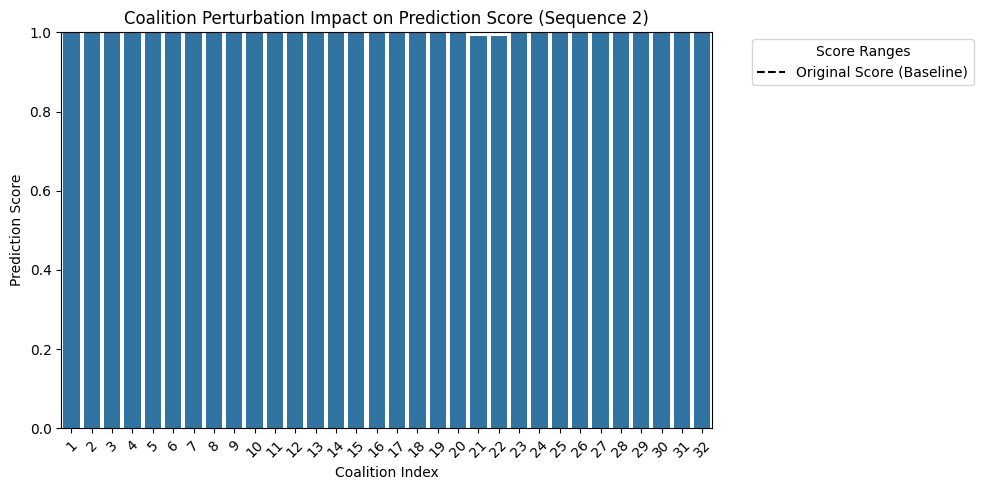

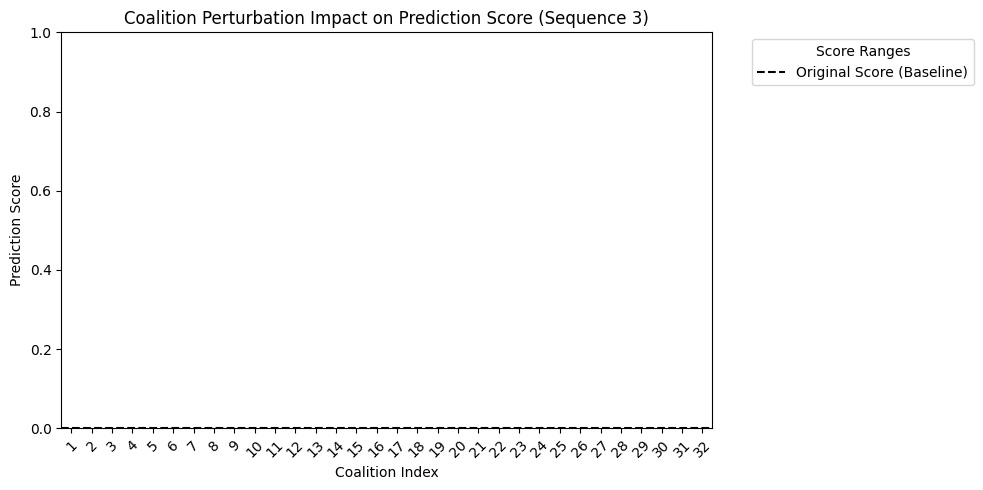

                 Original   Coalition 1   Coalition 2   Coalition 3  \
Sequence                                                              
Sequence 1   9.436728e-05  7.367110e-01  7.361596e-01  8.199056e-01   
Sequence 2   9.999986e-01  9.999999e-01  9.999999e-01  1.000000e+00   
Sequence 3   4.263769e-15  1.039329e-12  7.668345e-13  2.431679e-12   
Sequence 4   2.204960e-13  3.104244e-12  2.844661e-12  6.107995e-12   
Sequence 5   6.147454e-05  2.829603e-07  3.027469e-07  3.172424e-07   
Sequence 6   5.068399e-09  6.843374e-11  8.172999e-11  3.211544e-11   
Sequence 7   1.433715e-05  4.000636e-06  4.916555e-06  7.806784e-07   
Sequence 8   2.085589e-09  6.843374e-11  8.175446e-11  2.695133e-11   
Sequence 9   9.999008e-01  2.332131e-05  2.288971e-05  1.616999e-05   
Sequence 10  1.533184e-12  3.104244e-12  2.775094e-12  5.347166e-12   
Sequence 11  6.122618e-13  1.306876e-11  1.166263e-11  4.632128e-11   
Sequence 12  3.443955e-14  3.104244e-12  2.475188e-12  8.796821e-12   
Sequen

In [ ]:
# Plot all sequences after processing
plot_coalition_scores(prediction_results[1:3])

# Create and print the table
prediction_table = create_prediction_table(prediction_results)


### Step 2a: Perturbation Function : for feature-wise explanability
we should consider the number of independent variables (features) in the data ['Temp', 'Press', 'Hum', 'Wind'] i.e. 4 and Storm is the dependent variable being predicted.

In [ ]:
features = ['Temp', 'Press', 'Hum', 'Wind', 'Storm']

# --- Balancing ---
#df_majority = df_sequences[df_sequences.Storm == 0]
#df_minority = df_sequences[df_sequences.Storm == 1]

#df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
#df_balanced = pd.concat([df_majority, df_minority_upsampled]).sort_index()
df_balanced = df_sequences.copy()

# Function to generate all combinations in 2^m without repeating any combination
def generate_perturbations(sequence, sequence_id, background_values):
    perturbed_sequences = []
    print(f"Original Sequence {sequence_id}:\n", sequence)

    # Generate all possible combinations for 2^m
    num_features = len(features)
    combinations = list(product([0, 1], repeat=num_features))

    for coalition, combination in enumerate(combinations):
        perturbed_seq = sequence.copy()
        mask = pd.Series(combination, index=features)

        for feature in features:
            if mask[feature] == 0:
                perturbed_seq[feature] = background_values[feature]

        perturbed_seq['Mask'] = ''.join(map(str, combination))
        perturbed_sequences.append(perturbed_seq)
        print(f"Perturbed Sequence {sequence_id}; Coalition {coalition + 1}:\n", perturbed_seq)

    return perturbed_sequences

# Example usage of perturbation generation
sequence_id = 1
sequence = df_sequences[df_sequences['Sequence_ID'] == sequence_id].drop(columns=['Sequence_ID'])
perturbed_sequences = generate_perturbations(sequence, sequence_id, background_values)

Original Sequence 1:
         Date       Temp        Press        Hum       Wind  Storm
0 2025-01-01  20.496714  1010.097078  75.625667  16.441273      0
1 2025-01-02  21.269001  1012.375910  76.253740  14.267770      0
2 2025-01-03  23.434210  1012.084468  78.108889  17.556424      1
3 2025-01-04  25.633347  1013.782655  81.647948  17.065392      0
4 2025-01-05  25.118152  1014.960198  82.804996  16.694644      0
Perturbed Sequence 1; Coalition 1:
         Date       Temp        Press        Hum       Wind  Storm   Mask
0 2025-01-01  19.901192  1010.054526  74.990066  15.060831    0.0  00000
1 2025-01-02  19.901192  1010.054526  74.990066  15.060831    0.0  00000
2 2025-01-03  19.901192  1010.054526  74.990066  15.060831    0.0  00000
3 2025-01-04  19.901192  1010.054526  74.990066  15.060831    0.0  00000
4 2025-01-05  19.901192  1010.054526  74.990066  15.060831    0.0  00000
Perturbed Sequence 1; Coalition 2:
         Date       Temp        Press        Hum       Wind  Storm   Mask

### Step 2b: Model Prediction from All the Sequences: for feature-wise explanability


In [ ]:
features_for_explanability = ['Temp', 'Press', 'Hum', 'Wind']


df_balanced = df_sequences.copy()

# --- Feature-wise Coalitions ---
def generate_feature_wise_coalitions(sequence, background_values, features_for_explanability):
    feature_coalitions = []
    for combination in product([0, 1], repeat=len(features_for_explanability)):
        perturbed_seq = sequence.copy()
        mask = pd.DataFrame([combination] * len(sequence), columns=features_for_explanability, index=sequence.index)

        for feature in features_for_explanability:
            perturbed_seq.loc[mask[feature] == 0, feature] = background_values[feature]

        perturbed_seq['Mask'] = mask.apply(lambda row: ''.join(row.astype(int).astype(str)), axis=1)
        feature_coalitions.append(perturbed_seq)

    return feature_coalitions


# --- Data Preparation and Model Training (Sliding Window) ---
scaler_sw = MinMaxScaler()
scaler_sw.fit(df_balanced[features_for_explanability])

df_balanced_scaled_sw = df_balanced.copy()
df_balanced_scaled_sw[features_for_explanability] = scaler_sw.transform(df_balanced_scaled_sw[features_for_explanability])

X_train_sw, y_train_sw = [], []
for i in range(len(df_balanced_scaled_sw) - sequence_length + 1):
    seq_data = df_balanced_scaled_sw[features_for_explanability].iloc[i:i + sequence_length].values
    X_train_sw.append(seq_data[:-1])
    y_train_sw.append(df_balanced_scaled_sw['Storm'].iloc[i + sequence_length - 1])

X_train_sw = np.array(X_train_sw)
y_train_sw = np.array(y_train_sw)

model_sw = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(sequence_length - 1, len(features_for_explanability))),
    Dense(1, activation='sigmoid')
])

# changed epoch number from 50 to 200 - 14/2/2025
model_sw.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_sw = model_sw.fit(X_train_sw, y_train_sw, epochs=200, batch_size=4, validation_split=0.2, verbose=0)


# --- Data Preparation and Model Training (Fixed Sequence Length) ---
scaler_seq_length = MinMaxScaler()
scaler_seq_length.fit(df_balanced[features_for_explanability])

df_balanced_scaled_seq = df_balanced.copy()
df_balanced_scaled_seq[features_for_explanability] = scaler_seq_length.transform(df_balanced_scaled_seq[features_for_explanability])

X_train_seq_length, y_train_seq_length = [], []
for i in range(0, len(df_balanced_scaled_seq) - sequence_length + 1, sequence_length):
    seq_data = df_balanced_scaled_seq[features_for_explanability].iloc[i:i + sequence_length].values
    X_train_seq_length.append(seq_data[:-1])
    y_train_seq_length.append(df_balanced_scaled_seq['Storm'].iloc[i + sequence_length - 1])

X_train_seq_length = np.array(X_train_seq_length)
y_train_seq_length = np.array(y_train_seq_length)


model_seq_length = Sequential([Input(shape=(sequence_length - 1, len(features_for_explanability))), SimpleRNN(50, activation='relu'), Dense(1, activation='sigmoid')])

model_seq_length.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# changed epoch number from 50 to 200 - 14/2/2025
history_seq_length = model_seq_length.fit(X_train_seq_length, y_train_seq_length, epochs=200, batch_size=4, validation_split=0.2, verbose=0)


# --- Prediction Function ---
def make_predictions(sequence, perturbed_sequences, model, scaler, features_for_explanability, sequence_length):
    sequence_df = pd.DataFrame(sequence[features_for_explanability].iloc[:-1], columns=features_for_explanability)
    scaled_sequence = scaler.transform(sequence_df)
    scaled_sequence = scaled_sequence.reshape(1, sequence_length - 1, len(features_for_explanability))

    original_prediction = model.predict(scaled_sequence, verbose=0)

    perturbed_predictions = []
    for perturbed_seq in perturbed_sequences:
        perturbed_seq_df = pd.DataFrame(perturbed_seq[features_for_explanability].iloc[:-1], columns=features_for_explanability)
        scaled_perturbed_seq = scaler.transform(perturbed_seq_df)
        scaled_perturbed_seq = scaled_perturbed_seq.reshape(1, sequence_length - 1, len(features_for_explanability))
        perturbed_prediction = model.predict(scaled_perturbed_seq, verbose=0)
        perturbed_predictions.append(perturbed_prediction)

    return original_prediction, perturbed_predictions

# --- Prediction Loop (Sliding Window) ---
def predict_sliding_window(df, model, scaler, features, sequence_length, background_values, features_for_explanability):
    prediction_results = []
    print("Sliding Window Predictions:")
    for i in range(len(df) - sequence_length + 1):
        sequence = df.iloc[i:i + sequence_length].drop(columns=['Sequence_ID', 'Storm'])
        perturbed_sequences = generate_feature_wise_coalitions(sequence.copy(), background_values, features_for_explanability)
        original_prediction, perturbed_predictions = make_predictions(sequence, perturbed_sequences, model, scaler, features_for_explanability, sequence_length)

        print(f"\nSequence Starting at Index {i} Prediction: {original_prediction[0][0]:.4f}")
        for j, perturbed_prediction in enumerate(perturbed_predictions):
            print(f"Feature-Wise Coalition {j + 1} Prediction: {perturbed_prediction[0][0]:.4f}")

        prediction_results.append({
            "seq_id": i + 1,
            "original_prediction": original_prediction[0][0],
            "perturbed_predictions": [p[0][0] for p in perturbed_predictions]
        })
    return prediction_results

# --- Prediction Loop (Fixed Sequence Length) ---
def predict_fixed_sequence_length(df, model, scaler, features, sequence_length, background_values, features_for_explanability):
    prediction_results = []
    print("\nFixed Sequence Length Predictions:")
    for i in range(0, len(df) - sequence_length + 1, sequence_length):
        sequence = df.iloc[i:i + sequence_length].drop(columns=['Sequence_ID', 'Storm'])
        perturbed_sequences = generate_feature_wise_coalitions(sequence.copy(), background_values, features_for_explanability)
        original_prediction, perturbed_predictions = make_predictions(sequence, perturbed_sequences, model, scaler, features_for_explanability, sequence_length)
        print(f"\nSequence Starting at Index {i} Prediction: {original_prediction[0][0]:.4f}")
        for j, perturbed_prediction in enumerate(perturbed_predictions):
            print(f"Feature-Wise Coalition {j + 1} Prediction: {perturbed_prediction[0][0]:.4f}")

        prediction_results.append({
            "seq_id": i // sequence_length +1,
            "original_prediction": original_prediction[0][0],
            "perturbed_predictions": [p[0][0] for p in perturbed_predictions]
        })
    return prediction_results


# --- Call Prediction Function ---
prediction_results_sliding = predict_sliding_window(df_balanced, model_sw, scaler_sw, features, sequence_length, background_values, features_for_explanability) # Added features_for_explanability
prediction_results_fixed = predict_fixed_sequence_length(df_balanced, model_seq_length, scaler_seq_length, features, sequence_length, background_values, features_for_explanability) # Added features_for_explanability

# --- Plotting Coalition Scores (Fixed Sequence Length and Sliding Window) ---
def plot_coalition_scores(prediction_results, model_name):
    for result in prediction_results:
        seq_id = result["seq_id"]
        original_score = result["original_prediction"]
        coalition_scores = result["perturbed_predictions"]

        df_plot = pd.DataFrame({'Coalition': range(1, len(coalition_scores) + 1), 'Score': coalition_scores})

        plt.figure(figsize=(10, 5))
        ax = sns.barplot(data=df_plot, x="Coalition", y="Score")

        plt.axhline(y=original_score, color='black', linestyle='--', label="Original Score (Baseline)")

        plt.xlabel("Coalition Index")
        plt.ylabel("Prediction Score")
        plt.title(f"{model_name} - Coalition Perturbation Impact (Sequence {seq_id})")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.tight_layout()
        ax.set_ylim(0, 1)
        plt.show()


# --- Plotting Training History ---
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Sliding Window Predictions:

Sequence Starting at Index 0 Prediction: 0.0381
Feature-Wise Coalition 1 Prediction: 0.4520
Feature-Wise Coalition 2 Prediction: 0.0027
Feature-Wise Coalition 3 Prediction: 0.5341
Feature-Wise Coalition 4 Prediction: 0.0040
Feature-Wise Coalition 5 Prediction: 0.6636
Feature-Wise Coalition 6 Prediction: 0.0139
Feature-Wise Coalition 7 Prediction: 0.6031
Feature-Wise Coalition 8 Prediction: 0.0184
Feature-Wise Coalition 9 Prediction: 0.6493
Feature-Wise Coalition 10 Prediction: 0.0055
Feature-Wise Coalition 11 Prediction: 0.6621
Feature-Wise Coalition 12 Prediction: 0.0069
Feature-Wise Coalition 13 Prediction: 0.8766
Feature-Wise Coalition 14 Prediction: 0.0337
Feature-Wise Coalition 15 Prediction: 0.8054
Feature-Wise Coalition 16 Prediction: 0.0381

Sequence Starting at Index 1 Prediction: 0.9637
Feature-Wise Coalition 1 Prediction: 0.4520
Feature-Wise Coalition 2 Prediction: 0.9928
Feature-Wise Coalition 3 Prediction: 0.4370
Feature-Wise Coalition 4 Predic


Fixed Sequence Length Predictions:

Sequence Starting at Index 0 Prediction: 0.1307
Feature-Wise Coalition 1 Prediction: 0.1230
Feature-Wise Coalition 2 Prediction: 0.0650
Feature-Wise Coalition 3 Prediction: 0.1597
Feature-Wise Coalition 4 Prediction: 0.0909
Feature-Wise Coalition 5 Prediction: 0.1514
Feature-Wise Coalition 6 Prediction: 0.0736
Feature-Wise Coalition 7 Prediction: 0.2013
Feature-Wise Coalition 8 Prediction: 0.0920
Feature-Wise Coalition 9 Prediction: 0.1932
Feature-Wise Coalition 10 Prediction: 0.0949
Feature-Wise Coalition 11 Prediction: 0.2406
Feature-Wise Coalition 12 Prediction: 0.1278
Feature-Wise Coalition 13 Prediction: 0.2260
Feature-Wise Coalition 14 Prediction: 0.1121
Feature-Wise Coalition 15 Prediction: 0.2828
Feature-Wise Coalition 16 Prediction: 0.1307

Sequence Starting at Index 5 Prediction: 0.3214
Feature-Wise Coalition 1 Prediction: 0.1230
Feature-Wise Coalition 2 Prediction: 0.0926
Feature-Wise Coalition 3 Prediction: 0.2289
Feature-Wise Coalition 

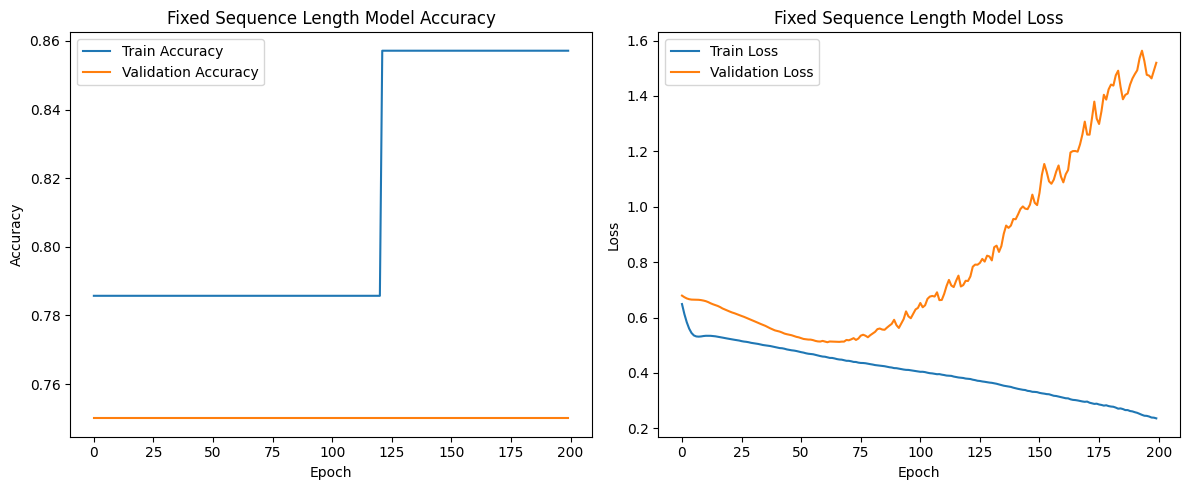

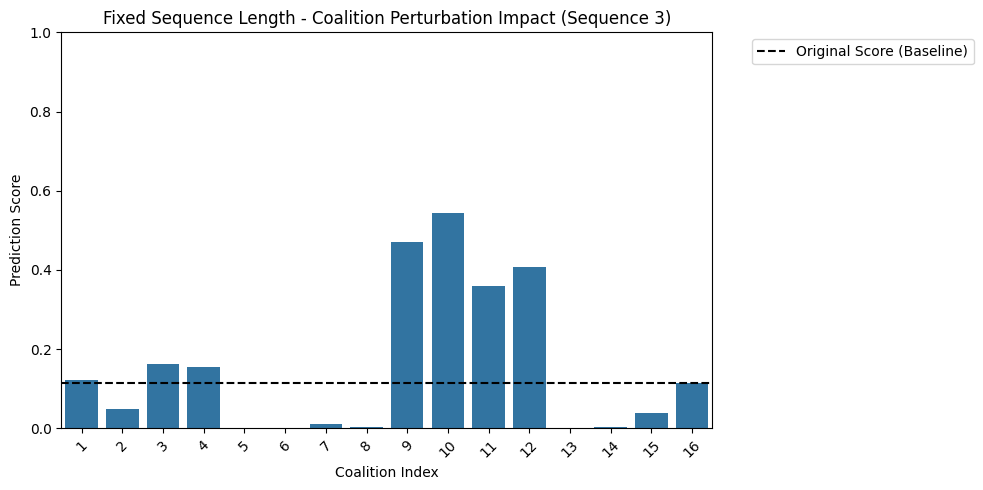

In [ ]:
## --- Call Prediction Functions for Fixed Sequence Length ---
prediction_results_fixed = predict_fixed_sequence_length(df_balanced, model_seq_length, scaler_seq_length, features, sequence_length, background_values, features_for_explanability)

plot_training_history(history_seq_length, "Fixed Sequence Length Model")

# **Select a specific sequence to plot (e.g., the first sequence)**
selected_sequence_fixed = prediction_results_fixed[2]
plot_coalition_scores([selected_sequence_fixed], "Fixed Sequence Length")


Sliding Window Predictions:

Sequence Starting at Index 0 Prediction: 0.0381
Feature-Wise Coalition 1 Prediction: 0.4520
Feature-Wise Coalition 2 Prediction: 0.0027
Feature-Wise Coalition 3 Prediction: 0.5341
Feature-Wise Coalition 4 Prediction: 0.0040
Feature-Wise Coalition 5 Prediction: 0.6636
Feature-Wise Coalition 6 Prediction: 0.0139
Feature-Wise Coalition 7 Prediction: 0.6031
Feature-Wise Coalition 8 Prediction: 0.0184
Feature-Wise Coalition 9 Prediction: 0.6493
Feature-Wise Coalition 10 Prediction: 0.0055
Feature-Wise Coalition 11 Prediction: 0.6621
Feature-Wise Coalition 12 Prediction: 0.0069
Feature-Wise Coalition 13 Prediction: 0.8766
Feature-Wise Coalition 14 Prediction: 0.0337
Feature-Wise Coalition 15 Prediction: 0.8054
Feature-Wise Coalition 16 Prediction: 0.0381

Sequence Starting at Index 1 Prediction: 0.9637
Feature-Wise Coalition 1 Prediction: 0.4520
Feature-Wise Coalition 2 Prediction: 0.9928
Feature-Wise Coalition 3 Prediction: 0.4370
Feature-Wise Coalition 4 Predic

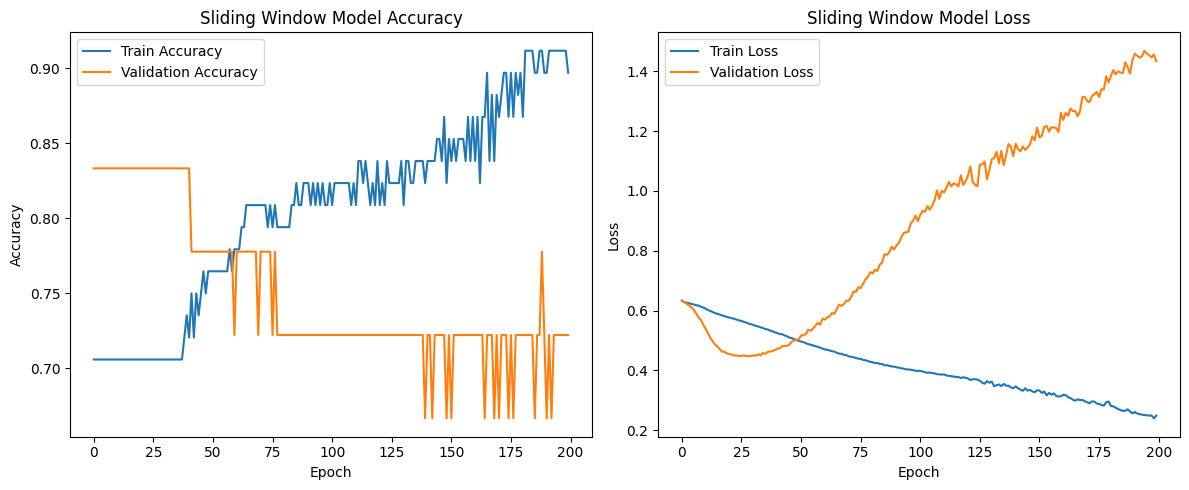

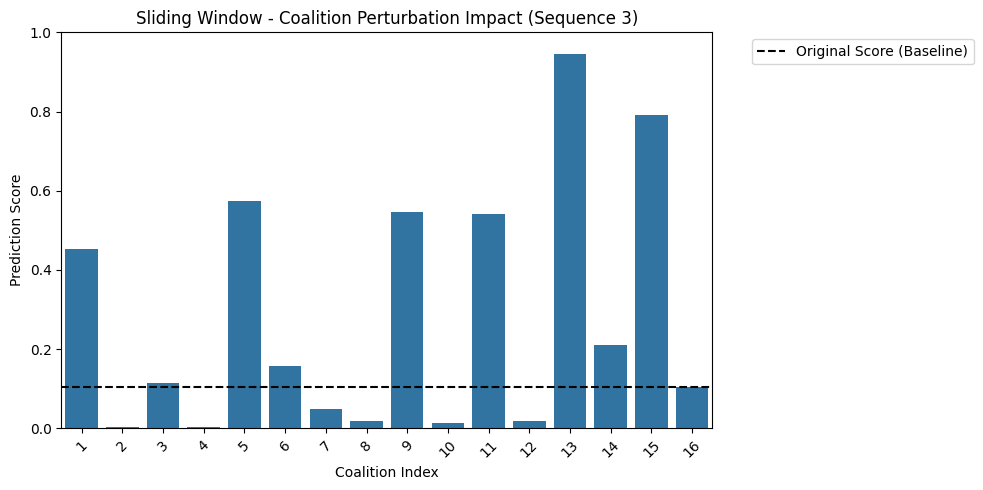

In [ ]:
## --- Call Prediction Functions for Sliding Window ---
prediction_results_sliding = predict_sliding_window(df_balanced, model_sw, scaler_sw, features, sequence_length, background_values, features_for_explanability)

plot_training_history(history_sw, "Sliding Window Model")

# **Select a specific sequence to plot (e.g., the first sequence)**
selected_sequence_sliding = prediction_results_sliding[2]
plot_coalition_scores([selected_sequence_sliding], "Sliding Window")

# =============================================================================
#   SECTION 3: Feature Importance
# ============================================================================



Sliding Window Feature Importances: {'Temp': 0.04545454, 'Press': 0.3636363, 'Hum': 0.3181818, 'Wind': 0.2727273}


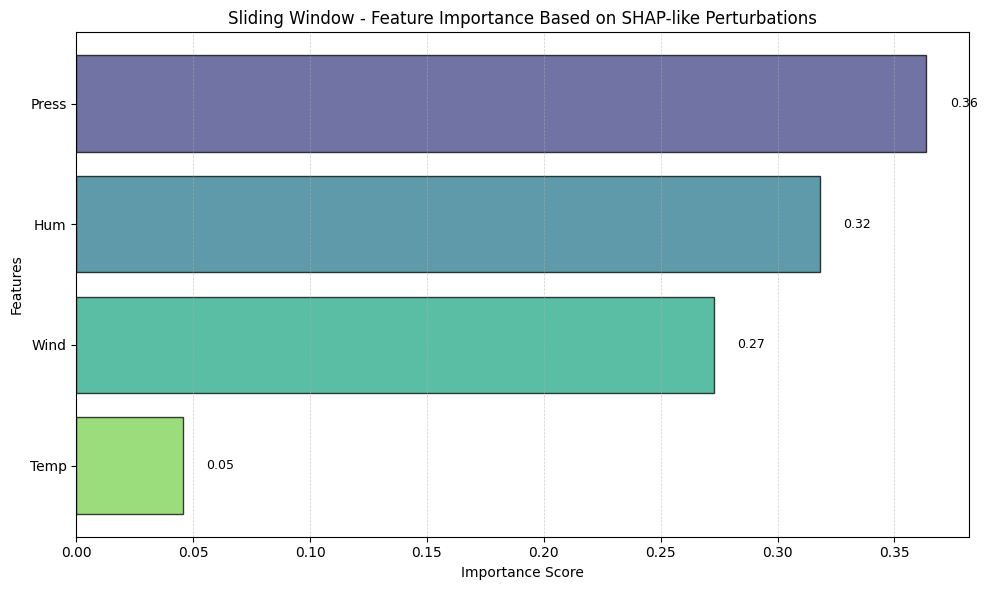


Fixed Sequence Length Feature Importances: {'Temp': 0.045454547, 'Press': 0.36363637, 'Hum': 0.31818184, 'Wind': 0.27272725}


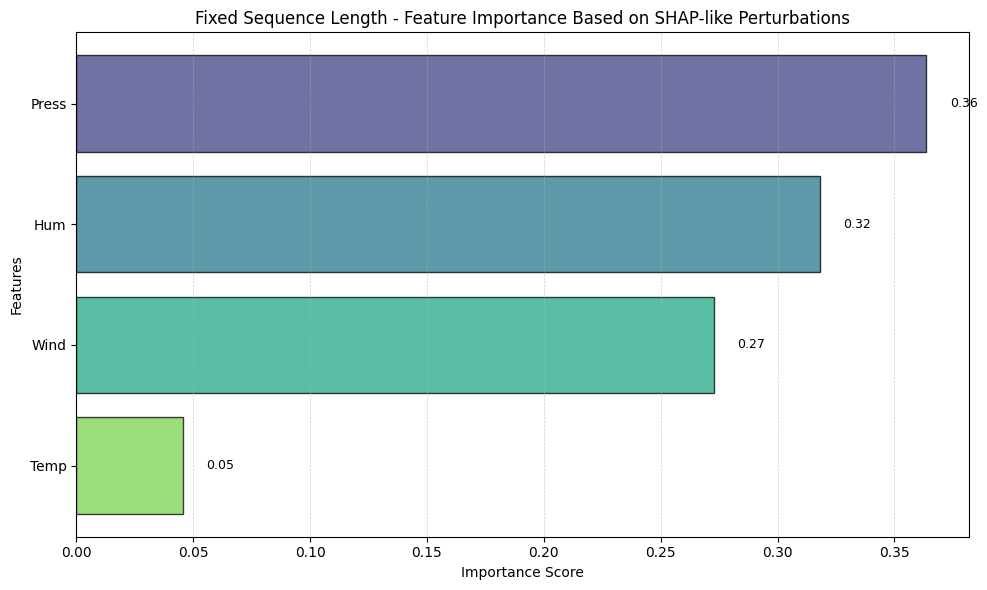

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **Improved Feature Importance Calculation**
def calculate_feature_importance(perturbed_sequences, original_prediction, features_for_explanability):
    feature_importances = {feature: 0 for feature in features_for_explanability}

    for perturbed_seq in perturbed_sequences:
        mask_str = ''.join(map(str, perturbed_seq['Mask'].astype(int)))

        for k, feature in enumerate(features_for_explanability):
            if mask_str[k] == '0':  # Feature was perturbed
                feature_importances[feature] += abs(original_prediction - perturbed_seq['Storm'].iloc[-1])

    #  **Normalize feature importances (avoid division by zero)**
    total_importance = sum(feature_importances.values())
    if total_importance > 0:
        feature_importances = {feature: imp / total_importance for feature, imp in feature_importances.items()}

    return feature_importances

# **Improved Feature Importance Plot with SHAP-like Style**
def plot_feature_importance(importances, model_name, features_for_explanability):
    plt.figure(figsize=(10, 6))

    #  **Sort features by importance**
    sorted_features = sorted(importances.keys(), key=lambda x: importances[x], reverse=True)
    sorted_values = [importances[feature] for feature in sorted_features]

    #  **Use consistent color mapping**
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(sorted_features)))

    plt.barh(sorted_features, sorted_values, color=colors, edgecolor='black', alpha=0.75)
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.title(f"{model_name} - Feature Importance Based on SHAP-like Perturbations")
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.6)

    #  **Display importance values on bars**
    for i, v in enumerate(sorted_values):
        plt.text(v + 0.01, i, f"{v:.2f}", va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

# **Feature Importance Calculation for Sliding Window**
sliding_window_importances = {}
for i in range(len(df_balanced) - sequence_length + 1):
    sequence = df_balanced.iloc[i:i + sequence_length].drop(columns=['Sequence_ID'])
    perturbed_sequences = generate_feature_wise_coalitions(sequence.copy(), background_values, features_for_explanability)

    # **Separate original sequence for prediction**
    sequence_for_prediction = sequence.drop(columns=['Storm'])
    perturbed_sequences_for_prediction = [seq.drop(columns=['Storm']) for seq in perturbed_sequences]

    original_prediction, _ = make_predictions(sequence_for_prediction, perturbed_sequences_for_prediction, model_sw, scaler_sw, features_for_explanability, sequence_length)
    feature_importances = calculate_feature_importance(perturbed_sequences, original_prediction, features_for_explanability)

    for feature, importance in feature_importances.items():
        sliding_window_importances.setdefault(feature, []).append(importance)

#  **Compute Mean Importances**
sliding_window_importances = {feature: np.mean(importances) for feature, importances in sliding_window_importances.items()}

print("\nSliding Window Feature Importances:", sliding_window_importances)
plot_feature_importance(sliding_window_importances, "Sliding Window", features_for_explanability)

#  **Feature Importance Calculation for Fixed Sequence Length**
fixed_seq_length_importances = {}
for i in range(0, len(df_balanced) - sequence_length + 1, sequence_length):
    sequence = df_balanced.iloc[i:i + sequence_length].drop(columns=['Sequence_ID'])
    perturbed_sequences = generate_feature_wise_coalitions(sequence.copy(), background_values, features_for_explanability)

    #  **Separate original sequence for prediction**
    sequence_for_prediction = sequence.drop(columns=['Storm'])
    perturbed_sequences_for_prediction = [seq.drop(columns=['Storm']) for seq in perturbed_sequences]

    original_prediction, _ = make_predictions(sequence_for_prediction, perturbed_sequences_for_prediction, model_seq_length, scaler_seq_length, features_for_explanability, sequence_length)
    feature_importances = calculate_feature_importance(perturbed_sequences, original_prediction, features_for_explanability)

    for feature, importance in feature_importances.items():
        fixed_seq_length_importances.setdefault(feature, []).append(importance)

# **Compute Mean Importances**
fixed_seq_length_importances = {feature: np.mean(importances) for feature, importances in fixed_seq_length_importances.items()}

print("\nFixed Sequence Length Feature Importances:", fixed_seq_length_importances)
plot_feature_importance(fixed_seq_length_importances, "Fixed Sequence Length", features_for_explanability)